<a href="https://colab.research.google.com/github/Sara1428/Deep-RL-for-Optimizing-Stock-Returns/blob/main/inverted_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gym

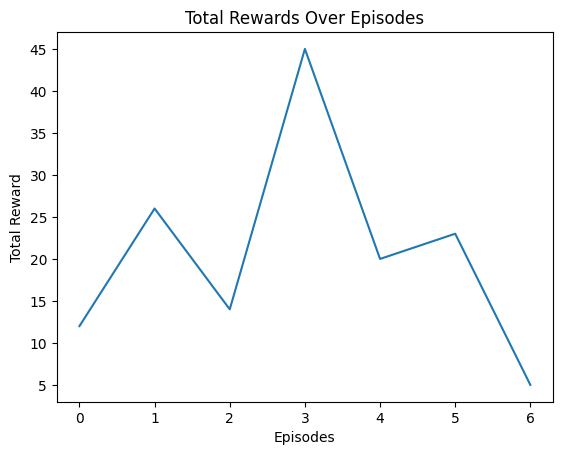

In [10]:
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
import time
timeout = time.time() + 60*15
# Initialize the environment
env = gym.make("CartPole-v1")

# Hyperparameters
alpha = 0.001          # Learning rate
gamma = 0.99           # Discount factor
epsilon = 1.0          # Exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon
min_epsilon = 0.01     # Minimum epsilon
episodes = 100        # Number of episodes
batch_size = 32        # Batch size for training

# Neural network model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(24, input_shape=(4,), activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha), loss='mse')
    return model

# Initialize model and memory
model = create_model()
memory = deque(maxlen=2000)

# Track rewards for plotting
rewards = []

# Training loop
for episode in range(episodes):
    if time.time() > timeout:
        break
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        if time.time() > timeout:
            break
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(state.reshape(1, -1), verbose=0))

        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        memory.append((state, action, reward, next_state, done))

        state = next_state
        if len(memory) > batch_size:
            minibatch = random.sample(memory, batch_size)
            for s, a, r, ns, d in minibatch:
                if time.time() > timeout:
                    break
                target = r + (1 - d) * gamma * np.max(model.predict(ns.reshape(1, -1), verbose=0))
                target_f = model.predict(s.reshape(1, -1), verbose=0)
                target_f[0][a] = target
                model.fit(s.reshape(1, -1), target_f, epochs=1, verbose=0)

    rewards.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

plt.plot(rewards)
plt.title("Total Rewards Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()

